We want to be able to find abundance values for each KO or ORF across samples. 

some helper functions below

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functions import get_filepath, find_clustered_orfs, find_orfs, find_orfs_from_cluster, find_cluster_from_orf
from functions import samples_from_soils, perturbed_pHs, native_pH, enriched_native_pH, perturbed_pH_sample, plot

DATDIR = '/projects/p32818/metagenomic_data/data'

soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']

native = np.zeros(len(soils))
for i, soil in enumerate(soils):
    native[i] = native_pH(soil)


In [101]:
import os

os.chdir('/gpfs/projects/p32818/metagenomic_data')

os.getcwd()

import importlib
import functions
importlib.reload(functions)

<module 'functions' from '/gpfs/projects/p32818/metagenomic_data/functions.py'>

## Construct ORF Abundance vs Native pH plot 

In [ ]:
#For T0, build a plot with rows which are cluster IDs and columns which are Native pH
ORFs = find_orfs(get_filepath('T0', 'annotation'), 'K00370')
ORF_list = list(ORFs)
samples = pd.read_csv(f'{DATDIR}/T0_sampleIDs.tsv', header=None)[0]
sample_list = list(samples)
metadata = pd.read_csv(f'{DATDIR}/metadata.tsv', sep = '\t')
metadata = metadata.set_index('sample')


chunk_size = 100000

data = np.zeros((len(ORFs), 20)) #data for plot stored here, each row is a dinstinct ORF, 

for chunk in pd.read_csv(get_filepath('T0', 'abundance'), sep='\s+', header=None,  chunksize = chunk_size):
    filtered_chunk = chunk[chunk.iloc[:, 1].isin(ORFs)]
    for i in range(len(filtered_chunk)):
        sample_id = filtered_chunk.iloc[i, 0]
        orf = filtered_chunk.iloc[i, 1]
        rel_abundance = filtered_chunk.iloc[i, 2]
        spikein = metadata.loc[sample_id, 'spikein_sum']
        row_idx = ORF_list.index(orf)
        col_idx = sample_list.index(sample_id)
        data[row_idx, col_idx] += rel_abundance/spikein
        
        
absolute_data = data

In [ ]:

np.savetxt("out/absolute_data_nar.tsv", np.array(data), delimiter = '\t', fmt = '%.6f')

/software/python-anaconda3/2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


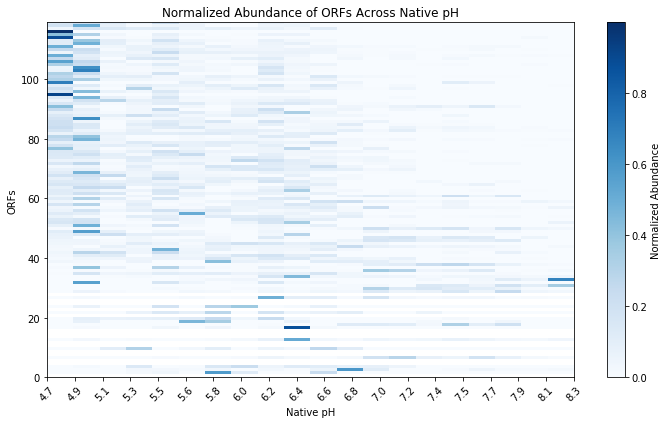

In [2]:
data = pd.read_csv("out/absolute_data_nar.tsv", sep='\t', header=None)
data = data.values
sorted_data = data[np.argsort(-np.abs(data[:, 0]))]
normalized_data = sorted_data / sorted_data.sum(axis=1, keepdims=True) #normalization step

x = np.linspace(4.7, 8.3, 20)


plt.figure(figsize=(10, 6))

plt.imshow(normalized_data, aspect='auto', cmap='Blues', extent=[x[0], x[-1], 0, data.shape[0]])

plt.xlabel('Native pH')
plt.ylabel('ORFs')
plt.title('Normalized Abundance of ORFs Across Native pH')

plt.colorbar(label='Normalized Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)

plt.tight_layout()
plt.show()

## Construct Cluster ID Abundance vs Native pH plot 

In [ ]:
#For T0, build a plot with rows which are cluster IDs and columns which are Native pH
ORFs = find_orfs(get_filepath('T0', 'annotation'), 'K00370')
ORF_list = list(ORFs)
print('\n ORFs \n')
print(ORF_list)
Cluster_IDs = ORF_list
for i in range(len(ORF_list)):
    Cluster_IDs[i] = find_cluster_from_orf(ORF_list[i])
    print(Cluster_IDs[i])
print('\n Clusters \n')
print(Cluster_IDs)
    

In [ ]:
IDs = np.array(Cluster_IDs)

sort_indices = np.argsort(-np.abs(data[:, 0])) 

sorted_data = data[sort_indices]
sorted_IDs = IDs[sort_indices]



In [ ]:

import numpy as np


# Dictionary to accumulate data
id_to_data = {} #given an id, the dictionary spits out the data array
for id, row in zip(sorted_IDs, sorted_data):
    if id in id_to_data:
        id_to_data[id] += row
    else:
        id_to_data[id] = row.copy()

# Reconstruct the arrays
unique_IDs = list(id_to_data.keys())
combined_data = np.array([id_to_data[id] for id in unique_IDs])

np.savetxt("out/cluster_ids.tsv", unique_IDs, delimiter = '\t', fmt = '%s')
np.savetxt("out/clustered_data_nar.tsv", combined_data, delimiter = '\t', fmt = '%0.6f')



In [2]:
cluster_IDs = pd.read_csv('out/cluster_ids.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values
print(cluster_IDs)
print(clustered_data)

normalized_data = clustered_data / clustered_data.sum(axis=1, keepdims=True) #normalization step

['T0.scaffold_610518454_c1_1', 'T0.scaffold_974243036_c1_1', 'T0.scaffold_51752605_c1_1', 'Soil14.scaffold_596019752_c1_119', 'T0.scaffold_519767388_c1_1', 'T0.scaffold_327279428_c1_4', 'T0.scaffold_273218771_c1_2', 'T0.scaffold_677904738_c1_1', 'T0.scaffold_967757664_c1_1', 'Soil5.scaffold_114379860_c1_1', 'Soil6.scaffold_604673340_c1_1', 'T0.scaffold_409096425_c1_1', 'T0.scaffold_82084267_c1_1', 'T0.scaffold_50999882_c1_2', 'T0.scaffold_61404940_c1_1', 'Soil3.scaffold_63658123_c1_64', 'Soil11.scaffold_594580914_c1_1', 'T0.scaffold_1146579158_c1_1', 'T0.scaffold_1087053736_c1_1', 'Soil3.scaffold_253488375_c1_4', 'Soil5.scaffold_416434691_c1_48', 'Soil6.scaffold_509384248_c1_7', 'T0.scaffold_287104333_c1_1', 'Soil14.scaffold_1008884942_c1_1', 'Soil9.scaffold_766455321_c1_2', 'Soil3.scaffold_31685847_c1_1', 'Soil5.scaffold_376523767_c1_1', 'Soil11.scaffold_437898375_c1_1', 'Soil5.scaffold_352638952_c1_1', 'Soil5.scaffold_342438982_c1_1', 'Soil6.scaffold_274716451_c1_1', 'Soil17.scaffold

/software/python-anaconda3/2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


## Find AA sequences from cluster IDs

In [ ]:
from Bio import SeqIO

def create_sequence_dict(fasta_file):
    return {record.id: str(record.seq) for record in SeqIO.parse(fasta_file, "fasta")}

# Load all sequences into memory first
seq_dict = create_sequence_dict("data/raw_data/all.coassembly_proteins_1st_ClusterDB_repseq.fasta")

# Now look up each ORF in the dictionary
for orf in cluster_IDs:
    sequence = seq_dict.get(orf, None)
    print(orf, 'sequence: ', sequence)

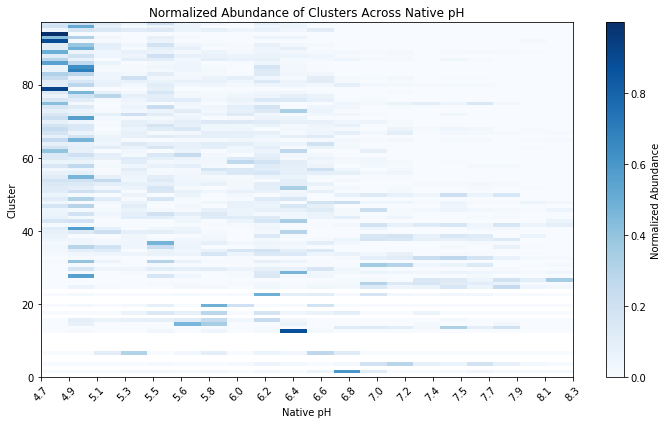

In [9]:

x = np.linspace(4.7, 8.3, 20)


plt.figure(figsize=(10, 6))

plt.imshow(normalized_data, aspect='auto', cmap='Blues', extent=[x[0], x[-1], 0, normalized_data.shape[0]])

plt.xlabel('Native pH')
plt.ylabel('Cluster')
plt.title('Normalized Abundance of Clusters Across Native pH')

plt.colorbar(label='Normalized Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)

plt.tight_layout()
plt.show()

Try PCA on the normalized data

/software/python-anaconda3/2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


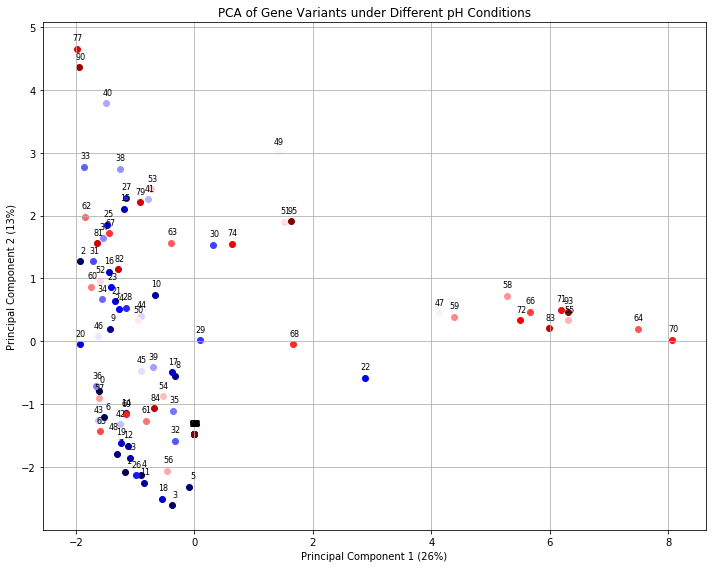

Principal Component 1: 26.96%
Principal Component 2: 13.04%
Principal Component 3: 8.23%
Principal Component 4: 7.40%
Principal Component 5: 6.21%
Principal Component 6: 5.93%
Principal Component 7: 4.82%
Principal Component 8: 4.44%
Principal Component 9: 3.94%
Principal Component 10: 3.29%


In [34]:

#try this: 
#nonneagive matrix factorization -- shows more signal when data is positive

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

clustered_data = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)
clustered_data = clustered_data.values 
normalized_data = clustered_data / clustered_data.sum(axis=1, keepdims=True)

data = np.nan_to_num(normalized_data)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


# Perform PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(scaled_data)


# Generate colors based on row index
row_indices = np.arange(principal_components.shape[0])
colors = plt.cm.seismic(row_indices / row_indices.max())

# Plot the first two principal components with row index labels
plt.figure(figsize=(10, 8))
for i in range(principal_components.shape[0]):
    plt.scatter(principal_components[i, 0], principal_components[i, 1], color=colors[i])
    plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')


plt.xlabel('Principal Component 1 (26%)')
plt.ylabel('Principal Component 2 (13%)')
plt.title('PCA of Gene Variants under Different pH Conditions')
plt.grid(True)
plt.tight_layout()
plt.show()

for i, ratio in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"Principal Component {i}: {ratio * 100:.2f}%")


/software/python-anaconda3/2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


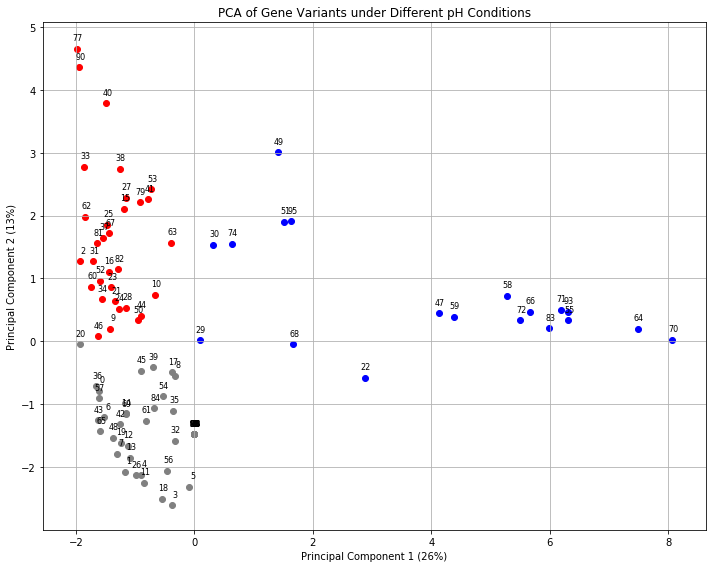

In [5]:

#try this: 
#nonneagive matrix factorization -- shows more signal when data is positive

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

clustered_data = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)
clustered_data = clustered_data.values 
normalized_data = clustered_data / clustered_data.sum(axis=1, keepdims=True)

data = np.nan_to_num(normalized_data)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

group1 = [] #the group of variants with a positive first compenent
group2 = [] #the group of variants with a negative first component, positive second componenet
group3 = [] #the group of variants with a negative first component, negative second componenet

# Plot the first two principal components with row index labels
plt.figure(figsize=(10, 8))
for i in range(principal_components.shape[0]):
    if principal_components[i, 0] > 0:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color='blue')
        plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')
        group1.append(i)
    elif principal_components[i, 1] > 0:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color='red')
        plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')
        group2.append(i)
    else:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color='grey')
        plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')
        group3.append(i)


plt.xlabel('Principal Component 1 (26%)')
plt.ylabel('Principal Component 2 (13%)')
plt.title('PCA of Gene Variants under Different pH Conditions')
plt.grid(True)
plt.tight_layout()
plt.show()


PCA on absolute data

In [ ]:
#checking cluster organization
cluster_IDs = pd.read_csv('out/cluster_ids.tsv')
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
cluster = cluster_IDs[4] #pick a cluster
ORFS = find_orfs_from_cluster(cluster)
abundance = np.zeros(20)
samples = pd.read_csv(f'{DATDIR}/T0_sampleIDs.tsv', header=None)[0]
sample_list = list(samples)

metadata = pd.read_csv('data/metadata.tsv', sep='\t')
metadata = metadata.set_index('sample')

chunk_size = 100000



#find its abundance array at T0
for chunk in pd.read_csv(get_filepath('T0', 'abundance'), sep='\s+', header=None,  chunksize = chunk_size):
    filtered_chunk = chunk[chunk.iloc[:, 1].isin(ORFS)]
    for i in range(len(filtered_chunk)):
        sample_id = filtered_chunk.iloc[i, 0]
        rel_abundance = filtered_chunk.iloc[i, 2]
        spikein = metadata.loc[sample_id, 'spikein_sum']
        idx = sample_list.index(sample_id)
        abundance[idx] += rel_abundance/spikein

print(abundance)

#cluster_IDs[3]: [0.20815558 0.15617367 0.01602243 0.00122829 0.03919204 0.011085250.00101163 0.0021338  0.02714269 0.02790571 0.         0.0.         0.00163234 0.         0.         0.         0.0.         0.        ]
#cluster_IDs[4]:[0.15574425 0.00228994 0.00155774 0.0008598  0.00964727 0.00064664 0.00118024 0.         0.         0.         0.         0. 0.         0.         0.         0.         0.         0. 0.00402874 0.        ]



[0.15574425 0.00228994 0.00155774 0.0008598  0.00964727 0.00064664
 0.00118024 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00402874 0.        ]


Note then: earlier in cluster ID list means enriched in a more acidic environment. labels on fig 1 y axis are backwards. 

## PCA on plot above 

## Clustering in Phenotype Space

group 1 [22, 29, 30, 47, 49, 51, 55, 58, 59, 64, 66, 68, 70, 71, 72, 74, 83, 93, 95]
group 2 [2, 9, 10, 15, 16, 21, 23, 24, 25, 27, 28, 31, 33, 34, 37, 38, 40, 41, 44, 46, 50, 52, 53, 60, 62, 63, 67, 77, 79, 81, 82, 90]
group 3 [0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 19, 20, 26, 32, 35, 36, 39, 42, 43, 45, 48, 54, 56, 57, 61, 65, 69, 73, 75, 76, 78, 80, 84, 85, 86, 87, 88, 89, 91, 92, 94, 96]


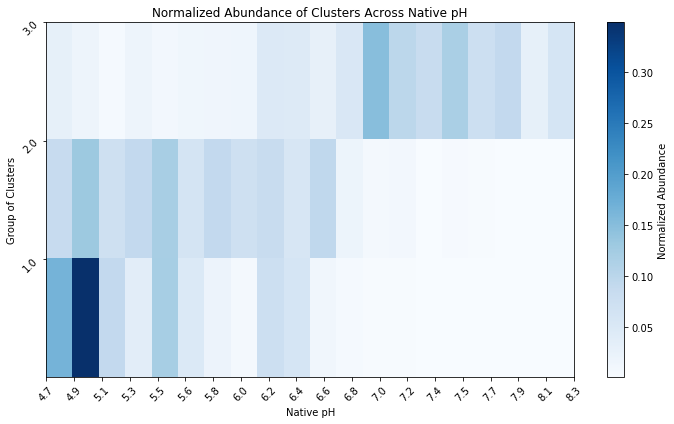

In [6]:
print('group 1', group1)
print('group 2', group2)
print('group 3', group3)

cluster_IDs = pd.read_csv('out/cluster_ids.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values


grouped_data = np.zeros((3, 20))

for i, datum in enumerate(clustered_data):
    if i in group1:
        grouped_data[0] += datum
    elif i in group2: 
        grouped_data[1] += datum
    else:
        grouped_data[2] += datum
        
normalized_data = grouped_data / grouped_data.sum(axis=1, keepdims=True) #normalization step

x = np.linspace(4.7, 8.3, 20)
y = np.linspace(1,3,3)


plt.figure(figsize=(10, 6))

plt.imshow(normalized_data, aspect='auto', cmap='Blues', extent=[x[0], x[-1], 0, normalized_data.shape[0]])

plt.xlabel('Native pH')
plt.ylabel('Group of Clusters')
plt.title('Normalized Abundance of Clusters Across Native pH')

plt.colorbar(label='Normalized Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)
plt.yticks(ticks=np.linspace(y[0], y[-1], len(y)), labels=[f"{val:.1f}" for val in y], rotation=45)

plt.tight_layout()
plt.show()

Try removing soil 1 and 2 from the PCA

In [45]:
print(group1)
print(group2)
print(group3)
print(len(group2))
print(len(group3))

[22, 29, 30, 47, 49, 51, 55, 58, 59, 64, 66, 68, 70, 71, 72, 74, 83, 93, 95]
[2, 9, 10, 15, 16, 21, 23, 24, 25, 27, 28, 31, 33, 34, 37, 38, 40, 41, 44, 46, 50, 52, 53, 60, 62, 63, 67, 77, 79, 81, 82, 90]
[0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 19, 20, 26, 32, 35, 36, 39, 42, 43, 45, 48, 54, 56, 57, 61, 65, 69, 73, 75, 76, 78, 80, 84, 85, 86, 87, 88, 89, 91, 92, 94, 96]
32
46


## Find a grouping which includes T0 and T9

Find all ORFs, including ones not present at T0. 

Produce a new array to perform PCA on, rows are all of the ORFs including new ones, columns include horizantally concatinated results for each soil sample. 

First try with just the 97 though. 

/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_4116/2932166153.py:3: RuntimeWarning: invalid value encountered in divide
  data = data / data.sum(axis=1, keepdims=True)
/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_4116/2932166153.py:10: RuntimeWarning: invalid value encountered in divide
  df = df / df.sum(axis = 1, keepdims=True)
/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_4116/2932166153.py:10: RuntimeWarning: invalid value encountered in divide
  df = df / df.sum(axis = 1, keepdims=True)
/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_4116/2932166153.py:10: RuntimeWarning: invalid value encountered in divide
  df = df / df.sum(axis = 1, keepdims=True)
/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_4116/2932166153.py:10: RuntimeWarning: invalid value encountered in divide
  df = df / df.sum(axis = 1, keepdims=True)
/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_4116/2932166153.py:10: RuntimeWarning: invalid v

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.15470707 0.21599664 0.12426291 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00489371 0.00082242 0.25340567]
 [0.         0.         0.         ... 0.01227448 0.00643981 0.09541121]
 [0.         0.         0.         ... 0.         0.         0.        ]]


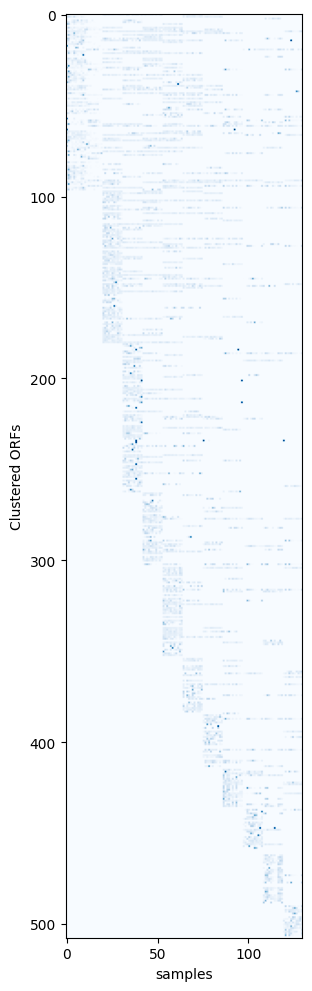

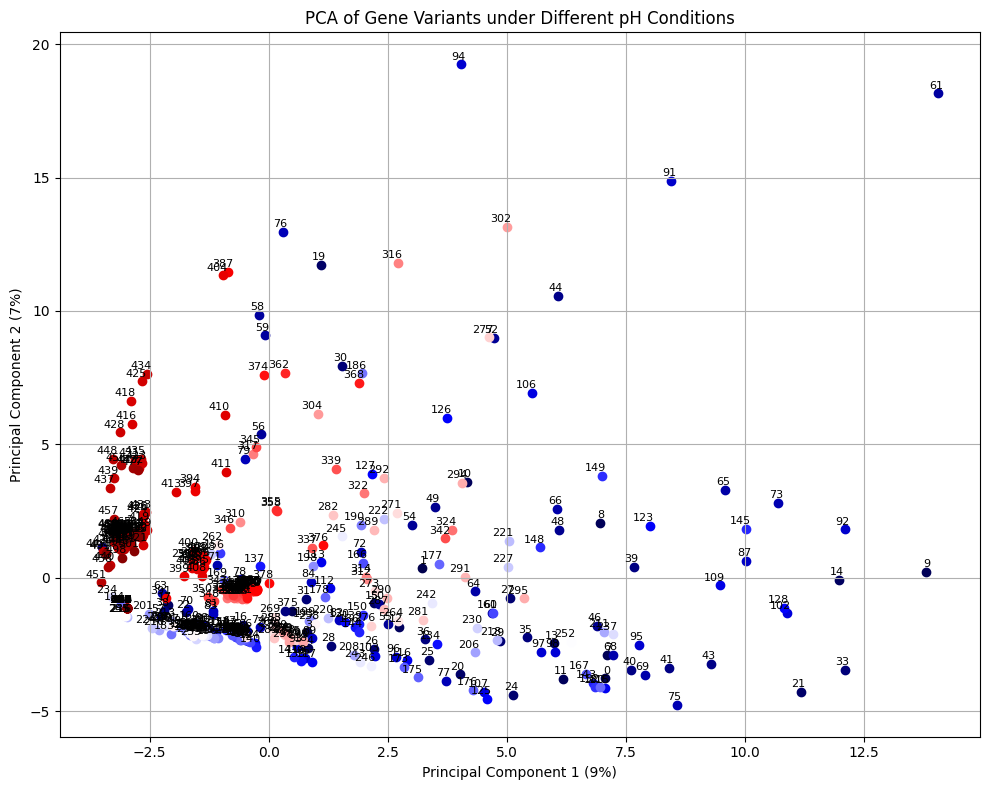

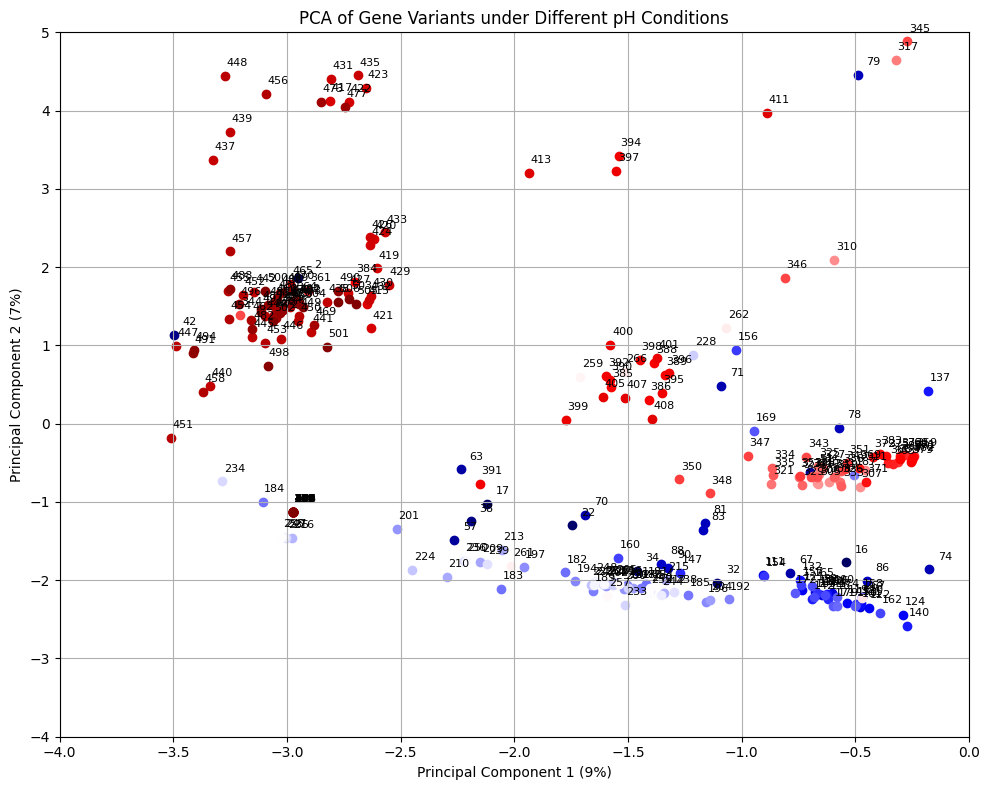

Principal Component 1: 8.82%
Principal Component 2: 7.37%
Principal Component 3: 4.44%
Principal Component 4: 4.16%
Principal Component 5: 3.96%
Principal Component 6: 3.71%
Principal Component 7: 3.53%
Principal Component 8: 3.37%
Principal Component 9: 3.04%
Principal Component 10: 2.82%


In [15]:
clustered_data = pd.read_csv('out/T0data_508_nar.tsv', sep='\t', header=None)
data = clustered_data.values
data = data / data.sum(axis=1, keepdims=True)


for soil in soils:
    filename = f"out/{soil}data_508_nar.tsv"  # Construct the filename
    df = pd.read_csv(filename, sep='\t', header = None)
    df = df.values
    df = df / df.sum(axis = 1, keepdims=True)
    data = np.hstack((data, df))
    
data = np.nan_to_num(data, nan = 0)
print(data)

plt.figure(figsize=(15,12))
plt.imshow(data, cmap = 'Blues')
plt.xlabel('samples')
plt.ylabel('Clustered ORFs')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA(n_components=10)
principal_components = pca.fit_transform(scaled_data)

# Generate colors based on row index
row_indices = np.arange(principal_components.shape[0])
colors = plt.cm.seismic(row_indices / row_indices.max())

# Plot the first two principal components with row index labels
plt.figure(figsize=(10, 8))
for i in range(principal_components.shape[0]):
    plt.scatter(principal_components[i, 0], principal_components[i, 1], color=colors[i])
    plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')


plt.xlabel('Principal Component 1 (9%)')
plt.ylabel('Principal Component 2 (7%)')
plt.title('PCA of Gene Variants under Different pH Conditions')
plt.grid(True)
plt.tight_layout()
plt.show()

# Generate colors based on row index
row_indices = np.arange(principal_components.shape[0])
colors = plt.cm.seismic(row_indices / row_indices.max())

# Plot the first two principal components with row index labels
plt.figure(figsize=(10, 8))
for i in range(principal_components.shape[0]):
    if (principal_components[i, 0] < 0 and principal_components[i, 1] < 5 and principal_components[i, 1] > -4):
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color=colors[i])
        plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')


plt.xlabel('Principal Component 1 (9%)')
plt.ylabel('Principal Component 2 (7%)')
plt.title('PCA of Gene Variants under Different pH Conditions')
plt.xlim(-4, 0)
plt.ylim(-4, 5)
plt.grid(True)
plt.tight_layout()
plt.show()



for i, ratio in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"Principal Component {i}: {ratio * 100:.2f}%")

In [9]:
#Find ORFs present in each soil sample

ORFs = find_orfs(get_filepath('T0', 'annotation_K00370'), 'K00370')
ORF_list = list(ORFs)
cluster_list = ORF_list
for i, orf in enumerate(ORF_list):
    cluster_list[i] = find_cluster_from_orf(orf)
    
cluster_IDs = cluster_list

for soil in soils:
    ORFs = find_orfs(get_filepath(soil, 'annotation_K00370'), 'K00370')
    ORF_list = list(ORFs)
    cluster_list = ORF_list
    for i, orf in enumerate(ORF_list):
        cluster_list[i] = find_cluster_from_orf(orf)
        
    cluster_IDs = cluster_IDs + cluster_list
    
print(cluster_IDs)
print(len(cluster_IDs))


#remove redundancy
unique_ids = []
for id in cluster_IDs:
    if id not in unique_ids:
        unique_ids.append(id)
        
print('unique')     
print(unique_ids)
print(len(unique_ids))

np.savetxt("out/complete_ids.tsv", unique_ids, delimiter = '\t', fmt = '%s')



['Soil5.scaffold_179483344_c1_1', 'T0.scaffold_610518454_c1_1', 'T0.scaffold_914934534_c1_1', 'T0.scaffold_1052029150_c1_1', 'Soil5.scaffold_352638952_c1_1', 'Soil5.scaffold_352638952_c1_1', 'T0.scaffold_519767388_c1_1', 'T0.scaffold_561169257_c1_1', 'T0.scaffold_1146579158_c1_1', 'Soil12.scaffold_898807201_c1_1', 'Soil17.scaffold_133787210_c1_1', 'Soil11.scaffold_231814530_c1_1', 'T0.scaffold_273218771_c1_2', 'Soil6.scaffold_441881540_c1_4', 'T0.scaffold_61404940_c1_1', 'T0.scaffold_61404940_c1_1', 'Soil9.scaffold_2866533_c1_1', 'Soil9.scaffold_301134466_c1_1', 'T0.scaffold_1146579158_c1_1', 'T0.scaffold_76076085_c1_1', 'Soil17.scaffold_133787210_c1_1', 'T0.scaffold_327279428_c1_4', 'T0.scaffold_847435721_c1_1', 'T0.scaffold_339049266_c1_1', 'Soil5.scaffold_114379860_c1_1', 'Soil5.scaffold_114379860_c1_1', 'Soil5.scaffold_114379860_c1_1', 'Soil6.scaffold_645328969_c1_1', 'T0.scaffold_961428012_c1_71', 'T0.scaffold_290627530_c1_1', 'Soil6.scaffold_200123076_c1_13', 'Soil6.scaffold_1301

In [12]:
print(samples_from_soils('Soil3'))

['Soil3_CE_239_-11_None_T9', 'Soil3_CE_239_-14_None_T9', 'Soil3_CE_239_-16_None_T9', 'Soil3_CE_239_-19_None_T9', 'Soil3_CE_239_-22_None_T9', 'Soil3_CE_239_-26_None_T9', 'Soil3_CE_239_-32_None_T9', 'Soil3_CE_239_-50_None_T9', 'Soil3_CE_239_-7_None_T9', 'Soil3_CE_239_0_None_T9', 'Soil3_CE_239_9_None_T9']


## Applying the new binning

In [52]:
native = np.zeros(len(soils))
print(soils)
for i, soil in enumerate(soils):
    native[i] = native_pH(soil)
    #print(soil, native[i])
    print(soil, perturbed_pHs(soil))
    
print(native)

print(native_pH('Soil1'))

['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']
Soil3 [3.486, 3.9330000000000003, 4.315, 4.712, 4.976, 5.444, 6.381, 6.778, 7.1739999999999995, 7.643, 8.22]
Soil5 [3.775, 4.163, 4.556, 5.156000000000001, 5.733, 6.332999999999999, 6.922000000000001, 7.21, 7.535, 7.811, 8.099]
Soil6 [3.847, 4.25, 4.628, 4.904, 5.492000000000001, 6.093, 6.502000000000001, 6.934, 7.318, 7.931, 8.48]
Soil9 [4.051, 4.373, 4.688, 5.144, 5.6610000000000005, 6.393, 6.862, 7.066, 7.497999999999999, 7.871, 8.53]
Soil11 [4.255, 4.4830000000000005, 4.784, 5.12, 5.21, 5.888999999999999, 6.537999999999999, 6.84, 7.497999999999999, 8.147, 8.58]
Soil12 [4.051, 4.363, 4.724, 4.837, 5.529, 6.0089999999999995, 6.441, 6.91, 7.426, 8.075, 8.243]
Soil14 [3.883, 4.4830000000000005, 4.748, 5.444, 6.1770000000000005, 6.72, 7.222, 7.667000000000001, 7.895, 8.279, 8.63]
Soil15 [4.279, 4.556, 4.772, 5.18, 5.565, 6.129, 6.682, 7.535, 8.033, 8.508, 8.59]
Soil16 [3.907, 4.195, 4.664, 4

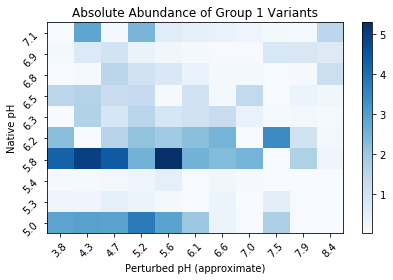

In [47]:
data = np.zeros((10,11))

group = group1

for j, soil in enumerate(soils):
    soil_data = pd.read_csv(f'out/{soil}data.tsv', sep='\t', header=None)
    soil_data = soil_data.values
    for i, datum in enumerate(soil_data):
        if i in group:
            data[j] += datum 

plot(data, 'Absolute Abundance of Group 1 Variants')

            

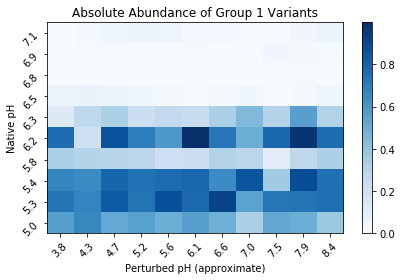

In [49]:
data = np.zeros((10,11))

group = group2

for j, soil in enumerate(soils):
    soil_data = pd.read_csv(f'out/{soil}data.tsv', sep='\t', header=None)
    soil_data = soil_data.values
    for i, datum in enumerate(soil_data):
        if i in group:
            data[j] += datum 


plot(data, 'Absolute Abundance of Group 1 Variants')


            

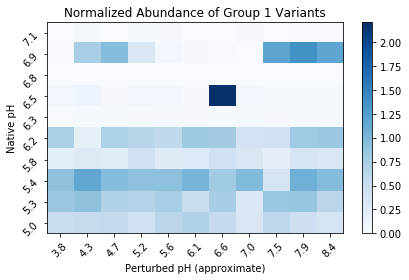

In [48]:
data = np.zeros((10,11))

group = group3

for j, soil in enumerate(soils):
    soil_data = pd.read_csv(f'out/{soil}data.tsv', sep='\t', header=None)
    soil_data = soil_data.values
    for i, datum in enumerate(soil_data):
        if i in group:
            data[j] += datum 

plot(data, 'Normalized Abundance of Group 1 Variants')


            

In [42]:
#first run "grouped data" box
selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
group1_T0_old = normalized_data[0][selected]
group2_T0_old = normalized_data[1][selected]
group3_T0_old = normalized_data[2][selected]

sum = np.sum(group1_T0_old)
group1_T0 = [x / sum for x in group1_T0_old]
sum = np.sum(group2_T0_old)
group2_T0 = [x / sum for x in group2_T0_old]
sum = np.sum(group3_T0_old)
group3_T0 = [x / sum for x in group3_T0_old]


In [43]:
print(group1_T0)
print(np.sum(group1_T0))

[0.19262061252619078, 0.28417632228648315, 0.12809959444774133, 0.19251625104169331, 0.12953104913581237, 0.04137150006852103, 0.01545865164392681, 0.0029881659314581325, 0.007634330111715751, 0.005603522806457385]
1.0000000000000002


## Or change in absolute abundance

[[2.886360e+00 2.573320e-01 5.301100e-02 4.268967e+00 2.249447e+00
  2.399000e-02 1.471980e+00 8.710000e-03 1.067730e-01 2.512800e-02]
 [2.942830e+00 2.185790e-01 7.914600e-02 4.963371e+00 1.050500e-02
  1.667512e+00 1.616766e+00 8.364500e-02 7.203790e-01 2.855469e+00]
 [2.912736e+00 4.887950e-01 1.287770e-01 4.442197e+00 1.569441e+00
  8.386780e-01 1.203199e+00 1.496910e+00 9.805010e-01 1.253590e-01]
 [3.763017e+00 3.279380e-01 2.682270e-01 2.527965e+00 2.140143e+00
  1.549453e+00 1.326009e+00 1.061772e+00 3.464390e-01 2.479535e+00]
 [2.917307e+00 1.210240e-01 4.958510e-01 5.295216e+00 1.937275e+00
  8.687000e-01 4.699500e-02 7.772280e-01 2.021680e-01 6.156630e-01]
 [2.025822e+00 3.291900e-02 2.949700e-02 2.542872e+00 2.231142e+00
  1.058994e+00 1.053006e+00 3.739320e-01 9.916700e-02 4.485360e-01]
 [2.900180e-01 2.907010e-01 1.940540e-01 2.323785e+00 2.519882e+00
  1.272777e+00 9.868300e-02 1.145270e-01 4.377200e-02 3.712800e-01]
 [4.047000e-02 8.272000e-03 4.813600e-02 2.525427e+00 3

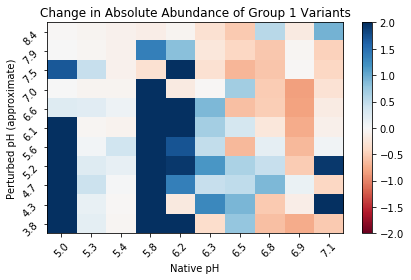

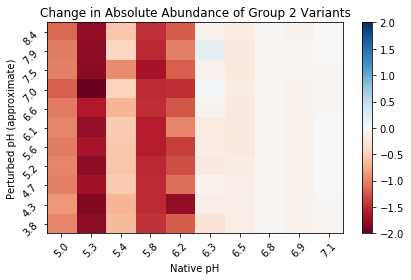

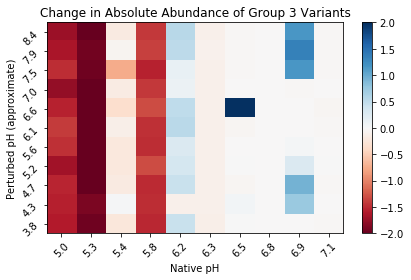

In [7]:

cluster_IDs = pd.read_csv('out/cluster_ids.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values


grouped_data = np.zeros((3, 20))

for i, datum in enumerate(clustered_data):
    if i in group1:
        grouped_data[0] += datum
    elif i in group2: 
        grouped_data[1] += datum
    else:
        grouped_data[2] += datum
        
selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
group1_T0 = grouped_data[0][selected]
group2_T0 = grouped_data[1][selected]
group3_T0 = grouped_data[2][selected]


data = np.zeros((10,11))

group = group1

for j, soil in enumerate(soils):
    soil_data = pd.read_csv(f'out/{soil}data.tsv', sep='\t', header=None)
    soil_data = soil_data.values
    for i, datum in enumerate(soil_data):
        if i in group:
            data[j] += datum 

np.savetxt('out/group1_T9.tsv', data, delimiter = '\t', fmt = '%0.6f')
data = data.T

plt.figure(figsize=(6, 4))


#subtract out T0 normalized abundance
print(data)

change = [[row[i] - group1_T0[i] for i in range(len(group1_T0))] for row in data]

group1_T0 = data - change
group1_T0 = group1_T0.T
print(group1_T0)
np.savetxt('out/group1_T0.tsv', group1_T0, delimiter = '\t', fmt = '%0.6f')

plt.imshow(change, aspect='auto', cmap='RdBu', origin='lower', vmin = -2, vmax = 2)
plt.colorbar()

plt.xlabel('Native pH')
plt.ylabel('Perturbed pH (approximate)')

y = np.linspace(3.8, 8.4, 11)
plt.yticks(ticks=np.linspace(0, 10, 11), labels=[f"{val:.1f}" for val in y], rotation=45)
plt.xticks(ticks=np.linspace(0, 9, 10), labels=[f"{val:.1f}" for val in native], rotation=45)


plt.title(label='Change in Absolute Abundance of Group 1 Variants')


plt.tight_layout()
plt.show()

data = np.zeros((10,11))

group = group2

for j, soil in enumerate(soils):
    soil_data = pd.read_csv(f'out/{soil}data.tsv', sep='\t', header=None)
    soil_data = soil_data.values
    for i, datum in enumerate(soil_data):
        if i in group:
            data[j] += datum 

np.savetxt('out/group2_T9.tsv', data, delimiter = '\t', fmt = '%0.6f')
data = data.T


plt.figure(figsize=(6, 4))


#subtract out T0 normalized abundance

change = [[row[i] - group2_T0[i] for i in range(len(group2_T0))] for row in data]

group2_T0 = data - change
group2_T0 = group2_T0.T
np.savetxt('out/group2_T0.tsv', group2_T0, delimiter = '\t', fmt = '%0.6f')

plt.imshow(change, aspect='auto', cmap='RdBu', origin='lower', vmin = -2, vmax = 2)
plt.colorbar()

plt.xlabel('Native pH')
plt.ylabel('Perturbed pH (approximate)')

y = np.linspace(3.8, 8.4, 11)
plt.yticks(ticks=np.linspace(0, 10, 11), labels=[f"{val:.1f}" for val in y], rotation=45)
plt.xticks(ticks=np.linspace(0, 9, 10), labels=[f"{val:.1f}" for val in native], rotation=45)


plt.title(label='Change in Absolute Abundance of Group 2 Variants')


plt.tight_layout()
plt.show()

data = np.zeros((10,11))

group = group3

for j, soil in enumerate(soils):
    soil_data = pd.read_csv(f'out/{soil}data.tsv', sep='\t', header=None)
    soil_data = soil_data.values
    for i, datum in enumerate(soil_data):
        if i in group:
            data[j] += datum 

np.savetxt('out/group3_T9.tsv', data, delimiter = '\t', fmt = '%0.6f')
data = data.T


plt.figure(figsize=(6, 4))


#subtract out T0 normalized abundance

change = [[row[i] - group3_T0[i] for i in range(len(group3_T0))] for row in data]

group3_T0 = data - change
group3_T0 = group3_T0.T
np.savetxt('out/group3_T0.tsv', group3_T0, delimiter = '\t', fmt = '%0.6f')


plt.imshow(change, aspect='auto', cmap='RdBu', origin='lower', vmin = -2, vmax = 2)
plt.colorbar()

plt.xlabel('Native pH')
plt.ylabel('Perturbed pH (approximate)')

y = np.linspace(3.8, 8.4, 11)
plt.yticks(ticks=np.linspace(0, 10, 11), labels=[f"{val:.1f}" for val in y], rotation=45)
plt.xticks(ticks=np.linspace(0, 9, 10), labels=[f"{val:.1f}" for val in native], rotation=45)


plt.title(label='Change in Absolute Abundance of Group 3 Variants')


plt.tight_layout()
plt.show()

## Construct Cluster ID vs Change in pH plot

The input of this will be a soil. It must be one of the soils that is actually perturbed. 

Then, given that soil sample, you immediately know the native pH and a set of perturbed pHs. We have metagenomic data for 11 (?) perturbed pHs per soil. We also have already collected the data for for T0 sample, which is the corresponding column in the data matrix above. 

First, gather the set of new pHs and new abundances for that sample. 

Note that there may be clusters not present in the T0 samples? But, we only want to consider the ones that are available at T0, so we can consider change.

This is completed in pH_perturbation.py, but some processing is below. 

perturbed soils are 3, 5, 6, 9, 11, 12, 14, 15, 16, 17

In [ ]:
#Soil3, 5, 6, 9, 11, 12, 14, 15, 16, 17
soil = 'Soil17'
print(perturbed_pHs(soil))
print(len(perturbed_pHs(soil)))

print(native_pH(soil))

print(samples_from_soils(soil))

In [ ]:
np.savetxt("out/soil3data.tsv", data, delimiter = '\t', fmt = '%0.6f')

In [ ]:
soil3data = pd.read_csv("out/Soil11data.tsv",sep='\t',header=None)
data = pd.read_csv("out/clustered_data_nar.tsv",sep='\t',header=None)
soil3data = soil3data.values
data = data.values

#extract data from first column for T0, so that we can really talk about change

soil = 'Soil11'

selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
#data = data[:, selected]
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']
index = soils.index(soil)
soil3_T0 = data[:, index]


In [ ]:
pHs = np.array(perturbed_pHs(soil))
sorted_indices = np.argsort(pHs)
sorted_pH = pHs[sorted_indices]
sorted_data = soil3data[:, sorted_indices]


In [ ]:
print(sorted_pH)

change_in_pH = sorted_pH.copy()
nativepH = native_pH(soil)

for i in range(len(sorted_pH)):
    change_in_pH[i] = sorted_pH[i] - nativepH

In [ ]:
change_in_abundance = sorted_data - soil3_T0[:,np.newaxis]

In [ ]:
plt.figure(figsize=(10, 6))

x = change_in_pH

plt.imshow(change_in_abundance, aspect='auto', cmap='coolwarm', extent=[x[0], x[-1], 0, change_in_abundance.shape[0]], vmin = -0.3, vmax = 0.3)

plt.xlabel('Change in pH')
plt.ylabel('Cluster')
plt.title(f'Change in Abundance per cluster, Native pH =  {nativepH}')

plt.colorbar(label='Change in Absolute Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

x = sorted_pH

plt.imshow(sorted_data, aspect='auto', cmap='coolwarm', extent=[x[0], x[-1], 0, sorted_data.shape[0]], vmin = 0, vmax = 0.1)

plt.xlabel('Change in pH')
plt.ylabel('Cluster')
plt.title('Change in Abundance per cluster, Native pH = 3.933')

plt.colorbar(label='Change in Absolute Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)

plt.tight_layout()
plt.show()

## Construct scatter plot where x is peak native pH, y is peak perturbed pH, dots are cluster IDs

Steps:

1. function -- enriched_native_pH defined above now 
    input: cluster ID, filtered data matrix
    output: soil where it is most enriched (out of the 11)



2. function
    input: cluster ID and soil
    output: perturbed pH where it is most enriched, given it started in that soil 


In [ ]:
#first, filter the data 
#we only want rows which are actually perturubed
cluster_IDs = pd.read_csv('metagenomic_data/out/cluster_ids.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('metagenomic_data/out/clustered_data_nar.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values

#soils perturbed: 3, 5, 6, 9, 11, 12, 14, 15, 16, 17
selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
data = clustered_data[:, selected]

print(len(data[0]))

print(enriched_native_pH(cluster_IDs[30], data, cluster_IDs))
print(samples_from_soils('Soil14'))



Given a cluster ID, we know the native pH where it is most enriched. Look at all of the perturbations which begin with that native pH, and identify which one of these it is most enriched in. 

In [ ]:
cluster_IDs = pd.read_csv('out/cluster_ids.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values

#soils perturbed: 3, 5, 6, 9, 11, 12, 14, 15, 16, 17
selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
filtered_data = clustered_data[:, selected]

data = np.zeros((len(cluster_IDs), 2))  #for each cluster ID, we want to specificfy a native pH and a perturbed pH where it is most enriched


for i, CID in enumerate(cluster_IDs):
    print(i)
    soil = enriched_native_pH(CID, filtered_data, cluster_IDs)
    data[i, 0] = native_pH(soil)
    #ORFs = find_orfs(get_filepath(soil, 'annotation'), 'K00370') #ORFs for the specified protein
    ORFs = find_orfs_from_cluster(CID) #ORFs for the specified cluster

    #Unique_IDs is the array, defined earlier, containing the list of cluster IDs

    sample_list = samples_from_soils(soil)

    metadata = pd.read_csv(f'{DATDIR}/metadata.tsv', sep = '\t')
    metadata = metadata.set_index('sample')

    chunk_size = 100000

    abundance = np.zeros(11) #for a given CID the specified soil, there are 11 perturbed samples

    for chunk in pd.read_csv(get_filepath(soil, 'abundance'), sep='\s+', header=None,  chunksize = chunk_size):
        filtered_chunk = chunk[chunk.iloc[:, 1].isin(ORFs)]
        for i in range(len(filtered_chunk)):
            sample_id = filtered_chunk.iloc[i, 0]
            if sample_id in sample_list:
                orf = filtered_chunk.iloc[i, 1]
                rel_abundance = filtered_chunk.iloc[i, 2]
                spikein = metadata.loc[sample_id, 'spikein_sum']
                idx = sample_list.index(sample_id)
                abundance[idx] += rel_abundance/spikein
                
    
    pHs = perturbed_pHs(soil)
    data[i, 1] = pHs[np.argmax(abundance)]

print(data)

In [ ]:
pHs = perturbed_pHs(soil)
print(np.argmax(abundance))
print(native_pH(soil))
print(pHs[np.argmax(abundance)])

Now, perform the steps above for each cluster ID

Note: this is completed by pH_perturbations2.py

In [ ]:
cluster_IDs = pd.read_csv('metagenomic_data/out/cluster_ids.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('metagenomic_data/out/clustered_data_nar.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values

#soils perturbed: 3, 5, 6, 9, 11, 12, 14, 15, 16, 17
selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
filtered_data = clustered_data[:, selected]

data = np.zeros((len(cluster_IDs), 2))  #for each cluster ID, we want to specificfy a native pH and a perturbed pH where it is most enriched


for i, CID in enumerate(cluster_IDs):
    print(i)
    soil = enriched_native_pH(CID, filtered_data, cluster_IDs)
    data[i, 0] = native_pH(soil)
    #ORFs = find_orfs(get_filepath(soil, 'annotation'), 'K00370') #ORFs for the specified protein
    ORFs = find_orfs_from_cluster(CID) #ORFs for the specified cluster

    #Unique_IDs is the array, defined earlier, containing the list of cluster IDs

    sample_list = samples_from_soils(soil)

    metadata = pd.read_csv(f'{DATDIR}/metadata.tsv', sep = '\t')
    metadata = metadata.set_index('sample')

    chunk_size = 100000

    abundance = np.zeros(11) #for a given CID the specified soil, there are 11 perturbed samples

    for chunk in pd.read_csv(get_filepath(soil, 'abundance'), sep='\s+', header=None,  chunksize = chunk_size):
        filtered_chunk = chunk[chunk.iloc[:, 1].isin(ORFs)]
        for i in range(len(filtered_chunk)):
            sample_id = filtered_chunk.iloc[i, 0]
            if sample_id in sample_list:
                orf = filtered_chunk.iloc[i, 1]
                rel_abundance = filtered_chunk.iloc[i, 2]
                spikein = metadata.loc[sample_id, 'spikein_sum']
                idx = sample_list.index(sample_id)
                abundance[idx] += rel_abundance/spikein
                
    
    pHs = perturbed_pHs(soil)
    data[i, 1] = pHs[np.argmax(abundance)]
    print(data[i])

print(data)

Text(0, 0.5, 'perturbed pH')

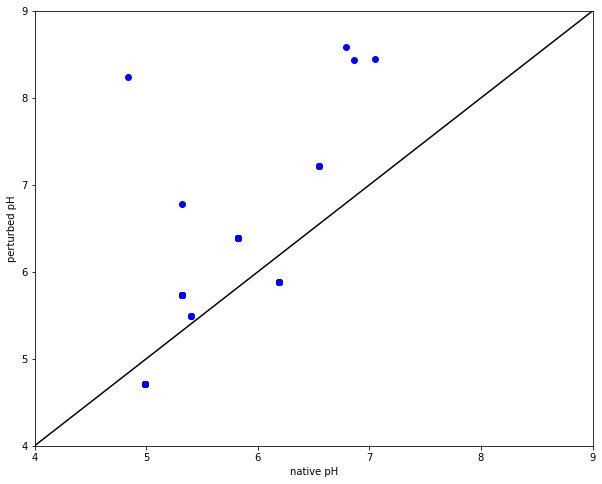

In [3]:
data = pd.read_csv('out/native_versus_perturbed_enchriment.tsv', sep='\t', header=None)
data = data.values
filtered_data = []
for pair in data:
    if pair[1] != 0:
        filtered_data.append(pair)
filtered_data = [data.tolist() for data in filtered_data]

x = [pair[0] for pair in filtered_data]
y = [pair[1] for pair in filtered_data]

plt.figure(figsize = (10,8))
plt.scatter(x,y, color = 'blue')
plt.xlim(4,9)
plt.ylim(4,9)

x1 = np.linspace(4,9,10)
y1 = x1
plt.plot(x1,y1, color = 'black')

plt.xlabel('native pH')
plt.ylabel('perturbed pH')


Text(0.5, 1.0, 'Blue = Present, White = Absent')

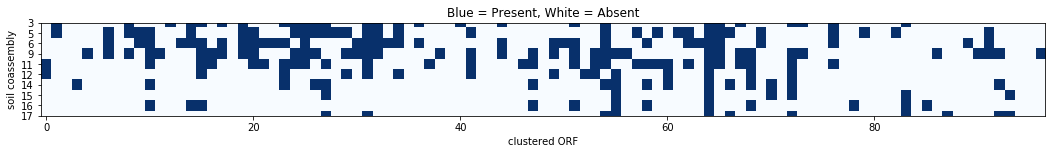

In [4]:
data = pd.read_csv('out/track_clusters.tsv', sep='\t', header=None)
data = data.values
data = data.T

plt.figure(figsize=(18,14))
plt.imshow(data, cmap = 'Blues')
plt.xlabel('clustered ORF')
plt.ylabel('soil coassembly')

labels = [3, 5, 6, 9, 11, 12, 14, 15, 16, 17]
plt.yticks(ticks=range(len(labels)), labels=labels)

plt.title('Blue = Present, White = Absent')

Text(0.5, 1.0, 'Blue = Present, White = Absent')

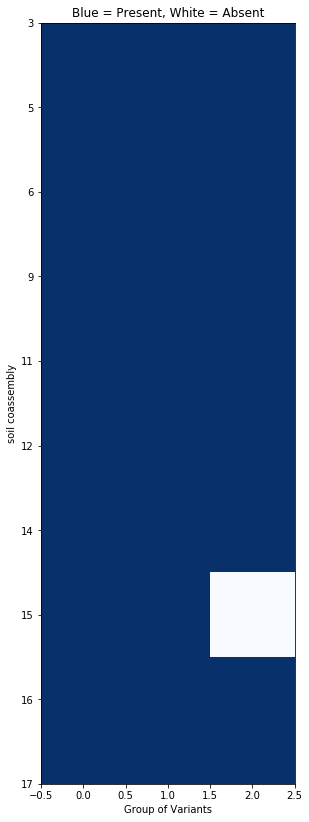

In [37]:
data = pd.read_csv('out/track_clusters.tsv', sep='\t', header=None)
data = data.values

grouped_data = np.zeros((3, 10))

for i, datum in enumerate(data):
    if i in group1:
        grouped_data[0] += datum
    if i in group2:
        grouped_data[1] += datum
    if i in group3:
        grouped_data[2] += datum 
        
for i in range(3):
    for j in range(10):
        if grouped_data[i][j] > 1:
            grouped_data[i][j] = 1
            
grouped_data = grouped_data.T

plt.figure(figsize=(18,14))
plt.imshow(grouped_data, cmap = 'Blues')
plt.xlabel('Group of Variants')
plt.ylabel('soil coassembly')

labels = [3, 5, 6, 9, 11, 12, 14, 15, 16, 17]
plt.yticks(ticks=range(len(labels)), labels=labels)

plt.title('Blue = Present, White = Absent')

In [56]:
print(samples_from_soils('Soil3'))

['Soil3_CE_239_-11_None_T9', 'Soil3_CE_239_-14_None_T9', 'Soil3_CE_239_-16_None_T9', 'Soil3_CE_239_-19_None_T9', 'Soil3_CE_239_-22_None_T9', 'Soil3_CE_239_-26_None_T9', 'Soil3_CE_239_-32_None_T9', 'Soil3_CE_239_-50_None_T9', 'Soil3_CE_239_-7_None_T9', 'Soil3_CE_239_0_None_T9', 'Soil3_CE_239_9_None_T9']


## Gathering functional dynamics

In [50]:
data= pd.read_csv('data/function_subset.tsv', sep='\t')

results = []

for soil in soils: 
    samples = samples_from_soils(soil)

    filt_data = data[(data["Soil"] == soil) & (data["Chloramphenicol"] == "None")]


    # Process each sample
    for sample in samples:
        parts = sample.split('_')
        if 'N' in parts[3]:
            unit = int(parts[4]) # e.g., -26
        else:
            unit = int(parts[3])

        # Filter rows matching the sample prefix in Soil_ID and matching Unit
        sample_rows = filt_data[(filt_data["Unit"] == unit)]


        t0_values = sample_rows[sample_rows["Time_point"].str.endswith("T0")]["NO3_mM"].values
        t3_values = sample_rows[sample_rows["Time_point"].str.endswith("T3")]["NO3_mM"].values
        t9_values = sample_rows[sample_rows["Time_point"].str.endswith("T9")]["NO3_mM"].values
        # Calculate initial slope and final value

        avg_t0 = t0_values.mean() if len(t0_values) > 0 else None
        avg_t3 = t3_values.mean() if len(t3_values) > 0 else None
        avg_t9 = t9_values.mean() if len(t9_values) > 0 else None

        # Calculate initial slope and final value
        initial_slope = (avg_t0 - avg_t3)/16.5 if avg_t0 is not None and avg_t3 is not None else None #units: decrease in nitrate per hour
        final_value = avg_t9


        # Append result
        results.append({
            "Soil": soil,
            "Sample_ID": sample,
            "Initial_Slope": round(initial_slope, 3),
            "Final_Value": round(final_value, 3)
        })



# Convert results to DataFrame and save to TSV
results_df = pd.DataFrame(results)
results_df.to_csv(f"out/function_summary.tsv", sep='\t', index=False)


print(results)

[{'Soil': 'Soil3', 'Sample_ID': 'Soil3_CE_239_-11_None_T9', 'Initial_Slope': 0.02, 'Final_Value': 0.629}, {'Soil': 'Soil3', 'Sample_ID': 'Soil3_CE_239_-14_None_T9', 'Initial_Slope': 0.021, 'Final_Value': 0.324}, {'Soil': 'Soil3', 'Sample_ID': 'Soil3_CE_239_-16_None_T9', 'Initial_Slope': 0.023, 'Final_Value': 0.395}, {'Soil': 'Soil3', 'Sample_ID': 'Soil3_CE_239_-19_None_T9', 'Initial_Slope': 0.022, 'Final_Value': 0.0}, {'Soil': 'Soil3', 'Sample_ID': 'Soil3_CE_239_-22_None_T9', 'Initial_Slope': 0.022, 'Final_Value': 0.0}, {'Soil': 'Soil3', 'Sample_ID': 'Soil3_CE_239_-26_None_T9', 'Initial_Slope': 0.045, 'Final_Value': 0.0}, {'Soil': 'Soil3', 'Sample_ID': 'Soil3_CE_239_-32_None_T9', 'Initial_Slope': 0.029, 'Final_Value': 0.0}, {'Soil': 'Soil3', 'Sample_ID': 'Soil3_CE_239_-50_None_T9', 'Initial_Slope': 0.006, 'Final_Value': 0.0}, {'Soil': 'Soil3', 'Sample_ID': 'Soil3_CE_239_-7_None_T9', 'Initial_Slope': 0.015, 'Final_Value': 0.735}, {'Soil': 'Soil3', 'Sample_ID': 'Soil3_CE_239_0_None_T9', 

[['Soil3' 'Soil3_CE_239_-11_None_T9' 0.02 0.629]
 ['Soil3' 'Soil3_CE_239_-14_None_T9' 0.021 0.324]
 ['Soil3' 'Soil3_CE_239_-16_None_T9' 0.023 0.395]
 ['Soil3' 'Soil3_CE_239_-19_None_T9' 0.022000000000000002 0.0]
 ['Soil3' 'Soil3_CE_239_-22_None_T9' 0.022000000000000002 0.0]
 ['Soil3' 'Soil3_CE_239_-26_None_T9' 0.045 0.0]
 ['Soil3' 'Soil3_CE_239_-32_None_T9' 0.028999999999999998 0.0]
 ['Soil3' 'Soil3_CE_239_-50_None_T9' 0.006 0.0]
 ['Soil3' 'Soil3_CE_239_-7_None_T9' 0.015 0.735]
 ['Soil3' 'Soil3_CE_239_0_None_T9' 0.011000000000000001 1.147]
 ['Soil3' 'Soil3_CE_239_9_None_T9' -0.0 1.528]
 ['Soil5' 'Soil5_CE_201_-12_None_T9' 0.02 0.0]
 ['Soil5' 'Soil5_CE_201_-15_None_T9' 0.022000000000000002 0.0]
 ['Soil5' 'Soil5_CE_201_-19_None_T9' 0.022000000000000002 0.0]
 ['Soil5' 'Soil5_CE_201_-23_None_T9' 0.019 0.0]
 ['Soil5' 'Soil5_CE_201_-28_None_T9' 0.018000000000000002 0.0]
 ['Soil5' 'Soil5_CE_201_-35_None_T9' 0.018000000000000002 0.0]
 ['Soil5' 'Soil5_CE_201_-5_None_T9' 0.012 0.72]
 ['Soil5' 'S

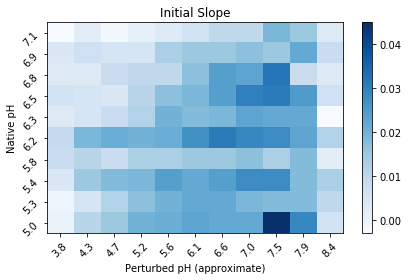

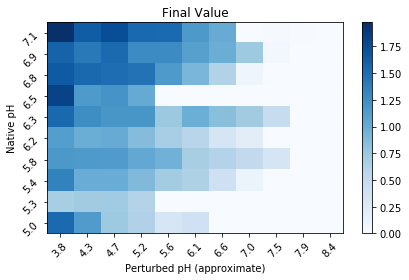

In [71]:
func_data = pd.read_csv('out/function_summary.tsv', sep='\t')
func_data = func_data.values
print(func_data)
print(samples_from_soils('Soil3'))
print(perturbed_pHs('Soil3'))

print(perturbed_pH_sample('Soil3_CE_239_-11_None_T9'))

data_slope = np.zeros((11, 10))
data_final = np.zeros((11, 10))
#native = native.tolist()
for datum in func_data:
    perturbed = perturbed_pHs(datum[0])
    perturbedpH = perturbed_pH_sample(datum[1])
    row_idx = perturbed.index(perturbedpH)
    nativepH = native_pH(datum[0])
    col_idx = native.index(nativepH)
    print('row idx = ', row_idx, 'col idx = ', col_idx)
    data_slope[row_idx][col_idx] = datum[2]
    data_final[row_idx][col_idx] = datum[3]
    

data_slope = data_slope.T
data_final = data_final.T

plot(data_slope, 'Initial Slope')

plot(data_final, 'Final Value')


np.savetxt("out/data_slope.tsv", data_slope, delimiter = '\t', fmt = '%0.6f')
np.savetxt("out/data_final.tsv", data_final, delimiter = '\t', fmt = '%0.6f')


## Plot Average Abudnances for each Group

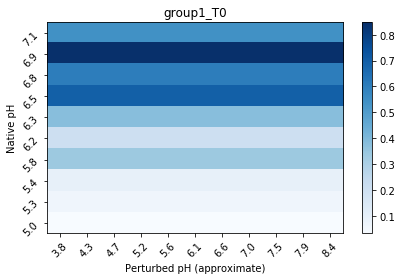

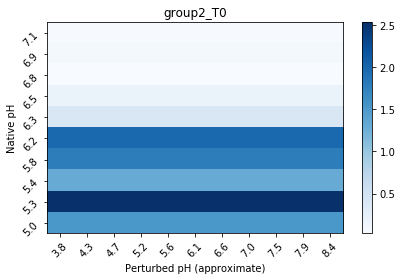

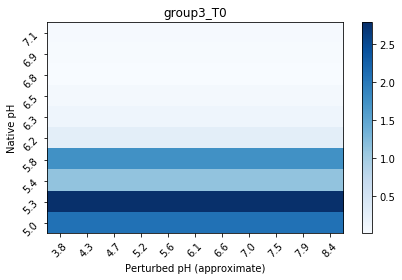

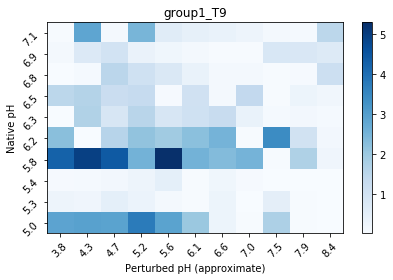

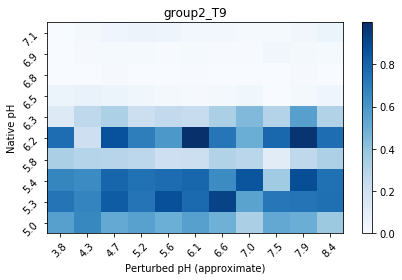

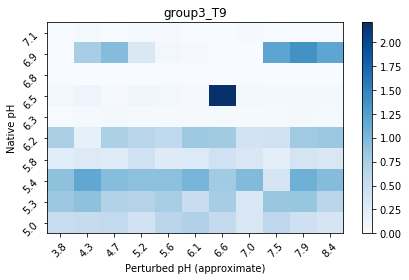

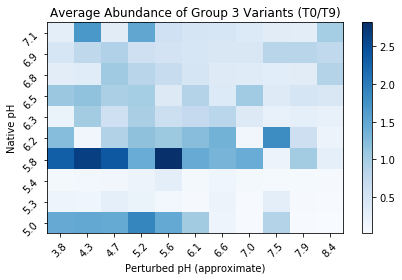

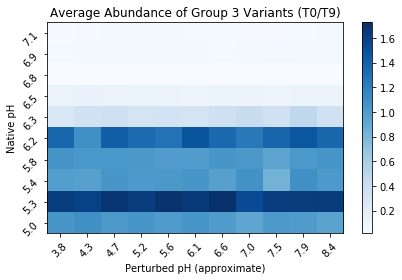

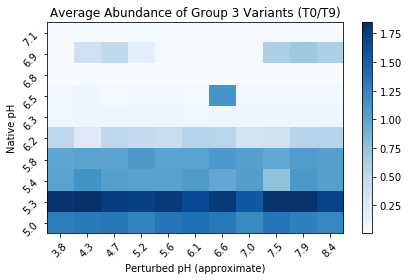

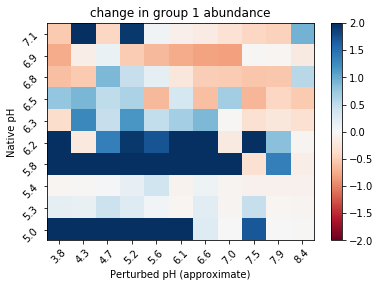

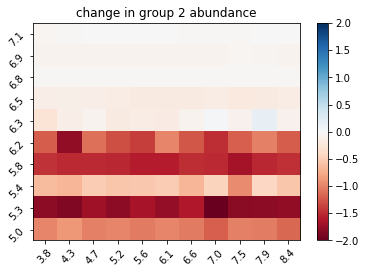

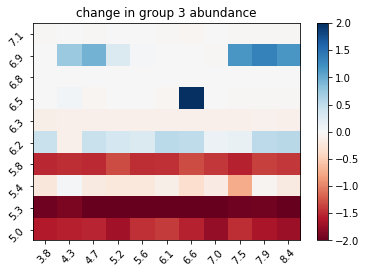

In [8]:
group1_T0 = pd.read_csv('out/group1_T0.tsv', sep='\t', header = None)
group1_T0 = group1_T0.values
group2_T0 = pd.read_csv('out/group2_T0.tsv', sep='\t', header = None)
group2_T0 = group2_T0.values
group3_T0 = pd.read_csv('out/group3_T0.tsv', sep='\t', header = None)
group3_T0 = group3_T0.values

group1_T9 = pd.read_csv('out/group1_T9.tsv', sep='\t', header = None)
group1_T9 = group1_T9.values
group2_T9 = pd.read_csv('out/group2_T9.tsv', sep='\t', header = None)
group2_T9 = group2_T9.values
group3_T9 = pd.read_csv('out/group3_T9.tsv', sep='\t', header = None)
group3_T9 = group3_T9.values

group1_avg = np.average([group1_T0, group1_T9], axis=0)
group2_avg = np.average([group2_T0, group2_T9], axis=0)
group3_avg = np.average([group3_T0, group3_T9], axis=0)

plot(group1_T0, 'group1_T0')
plot(group2_T0, 'group2_T0')
plot(group3_T0, 'group3_T0')

plot(group1_T9, 'group1_T9')
plot(group2_T9, 'group2_T9')
plot(group3_T9, 'group3_T9')


plot(group1_avg, 'Average Abundance of Group 3 Variants (T0/T9)')


plot(group2_avg, 'Average Abundance of Group 3 Variants (T0/T9)')

plot(group3_avg, 'Average Abundance of Group 3 Variants (T0/T9)')


x = np.linspace(3.8, 8.4, 11)

plt.xlabel('Perturbed pH (approximate)')
plt.ylabel('Native pH')


plt.imshow(group1_T9 - group1_T0, cmap = 'RdBu', origin = 'lower', aspect = 'auto', vmin = -2, vmax = 2)
plt.colorbar()
plt.xticks(ticks=np.linspace(0, 10, 11), labels=[f"{val:.1f}" for val in x], rotation=45)
plt.yticks(ticks=np.linspace(0, 9, 10), labels=[f"{val:.1f}" for val in native], rotation=45)
plt.title('change in group 1 abundance')
plt.show()

plt.imshow(group2_T9 - group2_T0, cmap = 'RdBu', origin = 'lower', aspect = 'auto', vmin = -2, vmax = 2)
plt.colorbar()
plt.xticks(ticks=np.linspace(0, 10, 11), labels=[f"{val:.1f}" for val in x], rotation=45)
plt.yticks(ticks=np.linspace(0, 9, 10), labels=[f"{val:.1f}" for val in native], rotation=45)
plt.title('change in group 2 abundance')
plt.show()

plt.imshow(group3_T9 - group3_T0, cmap = 'RdBu', origin = 'lower', aspect = 'auto', vmin = -2, vmax = 2)
plt.colorbar()
plt.xticks(ticks=np.linspace(0, 10, 11), labels=[f"{val:.1f}" for val in x], rotation=45)
plt.yticks(ticks=np.linspace(0, 9, 10), labels=[f"{val:.1f}" for val in native], rotation=45)
plt.title('change in group 3 abundance')
plt.show()

## Compute Mutual Information

Estimated mutual information between X and Y: 0.9465873015873019
Estimated mutual information between X and Y: 1.4431349206349224
Estimated mutual information between X and Y: 1.1402777777777793
Estimated mutual information between X and Y: 1.3611904761904774
Estimated mutual information between X and Y: 0.48206349206349275
Estimated mutual information between X and Y: 1.807500000000002
Estimated mutual information between X and Y: 0.7749603174603186
Estimated mutual information between X and Y: 0.010396825396825404
Estimated mutual information between X and Y: 0.30250000000000155
Estimated mutual information between X and Y: 0.05984126984127003
Estimated mutual information between X and Y: 0.0046825396825398435


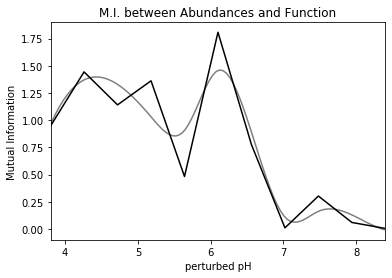

In [77]:
#first, fix a perturbed pH


from sklearn.feature_selection import mutual_info_regression


from scipy.interpolate import UnivariateSpline

data_slope = pd.read_csv('out/data_slope.tsv', sep='\t', header=None)
data_slope = data_slope.values
data_final = pd.read_csv('out/data_final.tsv', sep='\t', header=None)
data_final = data_final.values

group1_avg = group1_avg.T
group2_avg = group2_avg.T
group3_avg = group3_avg.T

data_slope = data_slope.T
data_final = data_final.T

MI_perturbed = np.zeros(11)

perturbed = np.linspace(3.8, 8.4, 11)

for i in range(len(MI_perturbed)):

    x1 = group1_avg[i]
    x2 = group2_avg[i]
    x3 = group3_avg[i]

    y1 = data_slope[i]
    y2 = data_final[i]

    X = np.column_stack((x1, x2, x3))
    Y = np.column_stack((y1, y2))


    mi_scores = [mutual_info_regression(X, Y[:, i], random_state=0) for i in range(Y.shape[1])]

    # Sum mutual information scores across Y dimensions
    
    total_mi = np.sum([np.sum(scores) for scores in mi_scores])
    MI_perturbed[i] = total_mi


    print(f"Estimated mutual information between X and Y: {total_mi}")
    
plt.plot(perturbed, MI_perturbed, color = 'black')
plt.xlim(3.8, 8.4)
plt.xlabel('perturbed pH')
plt.ylabel('Mutual Information')
plt.title('M.I. between Abundances and Function')



spline = UnivariateSpline(perturbed, MI_perturbed)
spline.set_smoothing_factor(0.5)

# Generate high-resolution x values
x_high = np.linspace(3.8, 8.4, 100)
y_high = spline(x_high)
plt.plot(x_high, y_high, color = 'black', alpha = 0.5)

np.savetxt("out/MI_perturbed.tsv", MI_perturbed, delimiter = '\t', fmt = '%0.6f')
np.savetxt("out/MI_perturbed_smooth.tsv", y_high, delimiter = '\t', fmt = '%0.6f')


Estimated mutual information between X and Y: 0.6761544011544032
Estimated mutual information between X and Y: 0.26172438672438814
Estimated mutual information between X and Y: 0.20959595959596156
Estimated mutual information between X and Y: 0.9091269841269878
Estimated mutual information between X and Y: 0.07168109668109812
Estimated mutual information between X and Y: 0.638419913419916
Estimated mutual information between X and Y: 1.6198773448773482
Estimated mutual information between X and Y: 0.09974747474747692
Estimated mutual information between X and Y: 0.639321789321794
Estimated mutual information between X and Y: 0.20248917748917927


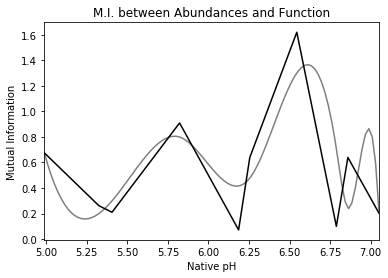

In [83]:
data_slope = pd.read_csv('out/data_slope.tsv', sep='\t', header=None)
data_slope = data_slope.values
data_final = pd.read_csv('out/data_final.tsv', sep='\t', header=None)
data_final = data_final.values

MI_native = np.zeros(10)

for i in range(len(MI_native)):

    x1 = group1_avg[i]
    x2 = group2_avg[i]
    x3 = group3_avg[i]

    y1 = data_slope[i]
    y2 = data_final[i]

    X = np.column_stack((x1, x2, x3))
    Y = np.column_stack((y1, y2))


    mi_scores = [mutual_info_regression(X, Y[:, i], random_state=0) for i in range(Y.shape[1])]

    # Sum mutual information scores across Y dimensions
    total_mi = np.sum([np.sum(scores) for scores in mi_scores])
    
    MI_native[i] = total_mi

    print(f"Estimated mutual information between X and Y: {total_mi}")
    
plt.plot(native, MI_native, color = 'black')
plt.xlim(min(native), max(native))
plt.xlabel('Native pH')
plt.ylabel('Mutual Information')
plt.title('M.I. between Abundances and Function')



spline = UnivariateSpline(native, MI_native)
spline.set_smoothing_factor(0.8)

# Generate high-resolution x values
x_high = np.linspace(min(native), max(native), 100)
y_high = spline(x_high)
plt.plot(x_high, y_high, color = 'black', alpha = 0.5)

np.savetxt("out/MI_native.tsv", MI_perturbed, delimiter = '\t', fmt = '%0.6f')
np.savetxt("out/MI_native_smooth.tsv", y_high, delimiter = '\t', fmt = '%0.6f')


One way to compute the mutual information at a point in native / perturbed space is by averaging the two marginal values at that point. This is not exactly right. 

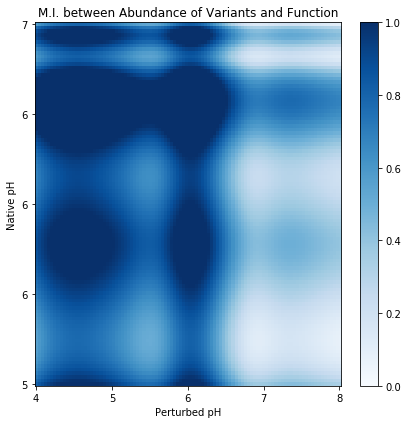

In [116]:
native_smooth = pd.read_csv('out/MI_native_smooth.tsv', sep = '\t', header = None)
perturb_smooth = pd.read_csv('out/MI_perturbed_smooth.tsv', sep = '\t', header = None)
native_smooth = native_smooth.values
perturb_smooth = perturb_smooth.values

data = np.zeros((100, 100))

for i in range(100):
    for j in range(100):
        data[i][j] = (native_smooth[i] + perturb_smooth[j])/2
        

# Define the min and max values for the axes
x_min, x_max = 3.8, 8.4# example range for y-axis
y_min, y_max = 5, 7 # example range for x-axis

    

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Display the matrix using imshow
cax = ax.imshow(data, cmap = 'Blues', origin='lower', aspect='auto', vmin = 0, vmax = 1)

# Set custom tick positions and labels
num_ticks = 5  # number of ticks to show
x_ticks = np.linspace(0, data.shape[1] - 1, num_ticks)
y_ticks = np.linspace(0, data.shape[0] - 1, num_ticks)
x_labels = np.linspace(x_min, x_max, num_ticks)
y_labels = np.linspace(y_min, y_max, num_ticks)

ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{label:.0f}" for label in x_labels])
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{label:.0f}" for label in y_labels])

# Add colorbar and labels
plt.colorbar(cax, ax=ax)
ax.set_xlabel("Perturbed pH")
ax.set_ylabel("Native pH")
ax.set_title("M.I. between Abundance of Variants and Function")

# Show the plot
plt.tight_layout()
plt.show()

abundance_MI = data


Next: Mutual Information between Native pH and function, across perturbed pH

Estimated mutual information between X and Y: 0.28174603174603186
Estimated mutual information between X and Y: 0.4859126984126987
Estimated mutual information between X and Y: 0.8111507936507938
Estimated mutual information between X and Y: 0.8429365079365085
Estimated mutual information between X and Y: 0.2729365079365076
Estimated mutual information between X and Y: 0.30257936507936534
Estimated mutual information between X and Y: 0.2623015873015877
Estimated mutual information between X and Y: 0
Estimated mutual information between X and Y: 0
Estimated mutual information between X and Y: 0.09301587301587344
Estimated mutual information between X and Y: 0.013730158730158593


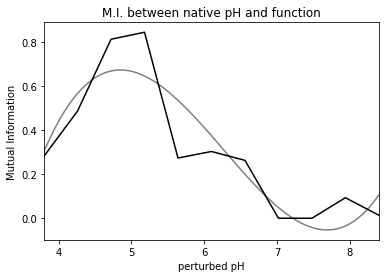

In [89]:
#first, fix a perturbed pH

from sklearn.feature_selection import mutual_info_regression


from scipy.interpolate import UnivariateSpline

data_slope = pd.read_csv('out/data_slope.tsv', sep='\t', header=None)
data_slope = data_slope.values
data_final = pd.read_csv('out/data_final.tsv', sep='\t', header=None)
data_final = data_final.values

group1_avg = group1_avg.T
group2_avg = group2_avg.T
group3_avg = group3_avg.T

data_slope = data_slope.T
data_final = data_final.T

MI_native_and_function = np.zeros(11)

perturbed = np.linspace(3.8, 8.4, 11)

for i in range(len(MI_native_and_function)):

    x = np.array(native).reshape(-1,1)

    y1 = data_slope[i]
    y2 = data_final[i]

    Y = np.column_stack((y1, y2))


    mi_scores = [mutual_info_regression(x, Y[:, i], random_state=0) for i in range(Y.shape[1])]

    # Sum mutual information scores across Y dimensions
    total_mi = np.sum([np.sum(scores) for scores in mi_scores])
    
    MI_native_and_function[i] = total_mi

    print(f"Estimated mutual information between X and Y: {total_mi}")
    
plt.plot(perturbed, MI_native_and_function, color = 'black')
plt.xlim(3.8, 8.4)
plt.xlabel('perturbed pH')
plt.ylabel('Mutual Information')
plt.title('M.I. between native pH and function')



spline = UnivariateSpline(perturbed, MI_native_and_function)
spline.set_smoothing_factor(0.5)

# Generate high-resolution x values
x_high = np.linspace(3.8, 8.4, 100)
y_high = spline(x_high)
plt.plot(x_high, y_high, color = 'black', alpha = 0.5)

np.savetxt("out/MI_native_and_function.tsv", MI_native_and_function, delimiter = '\t', fmt = '%0.6f')
np.savetxt("out/MI_native_and_function_smooth.tsv", y_high, delimiter = '\t', fmt = '%0.6f')


Next, mutual information between perturbed pH and function, across native pH

Estimated mutual information between X and Y: 0.909235209235211
Estimated mutual information between X and Y: 0.7372655122655136
Estimated mutual information between X and Y: 1.0304473304473323
Estimated mutual information between X and Y: 1.1282828282828299
Estimated mutual information between X and Y: 1.2267676767676783
Estimated mutual information between X and Y: 1.1525252525252538
Estimated mutual information between X and Y: 1.05858585858586
Estimated mutual information between X and Y: 1.0462481962481978
Estimated mutual information between X and Y: 1.1169191919191932
Estimated mutual information between X and Y: 1.148737373737375


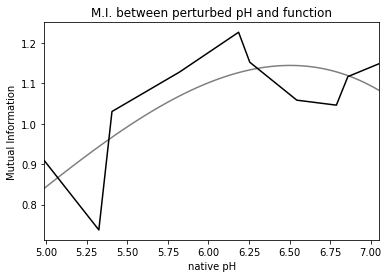

In [93]:
#first, fix a perturbed pH

data_slope = pd.read_csv('out/data_slope.tsv', sep='\t', header=None)
data_slope = data_slope.values
data_final = pd.read_csv('out/data_final.tsv', sep='\t', header=None)
data_final = data_final.values

group1_avg = group1_avg.T
group2_avg = group2_avg.T
group3_avg = group3_avg.T

MI_perturb_and_function = np.zeros(10)

perturbed = np.linspace(3.8, 8.4, 11)

for i in range(len(MI_perturb_and_function)):

    x = perturbed.reshape(-1,1)

    y1 = data_slope[i]
    y2 = data_final[i]

    Y = np.column_stack((y1, y2))


    mi_scores = [mutual_info_regression(x, Y[:, i], random_state=0) for i in range(Y.shape[1])]

    # Sum mutual information scores across Y dimensions
    total_mi = np.sum([np.sum(scores) for scores in mi_scores])
    
    MI_perturb_and_function[i] = total_mi

    print(f"Estimated mutual information between X and Y: {total_mi}")
    
plt.plot(native, MI_perturb_and_function, color = 'black')
plt.xlim(min(native), max(native))
plt.xlabel('native pH')
plt.ylabel('Mutual Information')
plt.title('M.I. between perturbed pH and function')



spline = UnivariateSpline(native, MI_perturb_and_function)
spline.set_smoothing_factor(0.5)

# Generate high-resolution x values
x_high = np.linspace(min(native), max(native), 100)
y_high = spline(x_high)
plt.plot(x_high, y_high, color = 'black', alpha = 0.5)

np.savetxt("out/MI_perturb_and_function.tsv", MI_native_and_function, delimiter = '\t', fmt = '%0.6f')
np.savetxt("out/MI_perturb_and_function_smooth.tsv", y_high, delimiter = '\t', fmt = '%0.6f')

Next, native versus perturbed pH, pixes are mutual information between (native and perturbed) pH and function

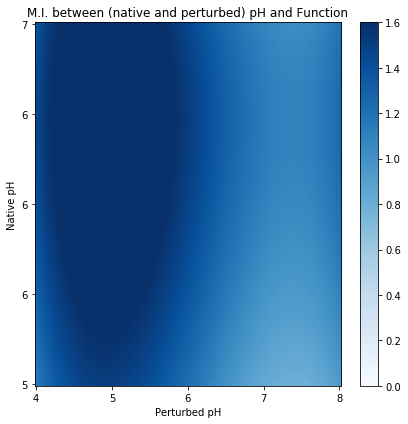

In [12]:
MIperturb = pd.read_csv('out/MI_perturb_and_function_smooth.tsv', sep = '\t', header = None)
MInative = pd.read_csv('out/MI_native_and_function_smooth.tsv', sep = '\t', header = None)
MIperturb = MIperturb.values
MInative = MInative.values

data = np.zeros((100, 100))

for i in range(100):
    for j in range(100):
        data[i][j] = MIperturb[i] + MInative[j]
        

# Define the min and max values for the axes
x_min, x_max = 3.8, 8.4# example range for y-axis
y_min, y_max = 5, 7 # example range for x-axis

    

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Display the matrix using imshow
cax = ax.imshow(data, cmap = 'Blues', origin='lower', aspect='auto', vmin = 0, vmax = 1.6)

# Set custom tick positions and labels
num_ticks = 5  # number of ticks to show
x_ticks = np.linspace(0, data.shape[1] - 1, num_ticks)
y_ticks = np.linspace(0, data.shape[0] - 1, num_ticks)
x_labels = np.linspace(x_min, x_max, num_ticks)
y_labels = np.linspace(y_min, y_max, num_ticks)

ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{label:.0f}" for label in x_labels])
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{label:.0f}" for label in y_labels])

# Add colorbar and labels
plt.colorbar(cax, ax=ax)
ax.set_xlabel("Perturbed pH")
ax.set_ylabel("Native pH")
ax.set_title("M.I. between (native and perturbed) pH and Function")

# Show the plot
plt.tight_layout()
plt.show()


In [1]:
MIperturb = pd.read_csv('out/MI_perturb_and_function_smooth.tsv', sep = '\t', header = None)
MIperturb = MIperturb.values

data = np.zeros((100, 100))

for i in range(100):
    for j in range(100):
        data[i][j] = MIperturb[j]

print(data)

data = data.T
    
# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Display the matrix using imshow
cax = ax.imshow(data, cmap = 'Blues', origin='lower', aspect='auto', vmin = 0.8, vmax = 1.3)

# Set custom tick positions and labels
num_ticks = 5  # number of ticks to show
x_ticks = np.linspace(0, data.shape[1] - 1, num_ticks)
y_ticks = np.linspace(0, data.shape[0] - 1, num_ticks)
x_labels = np.linspace(x_min, x_max, num_ticks)
y_labels = np.linspace(y_min, y_max, num_ticks)

ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{label:.0f}" for label in x_labels])
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{label:.0f}" for label in y_labels])

# Add colorbar and labels
plt.colorbar(cax, ax=ax)
ax.set_xlabel("Perturbed pH")
ax.set_ylabel("Native pH")
ax.set_title("Perturbed pH and Function")

# Show the plot
plt.tight_layout()
plt.show()
    
pH_MI = data

NameError: name 'pd' is not defined

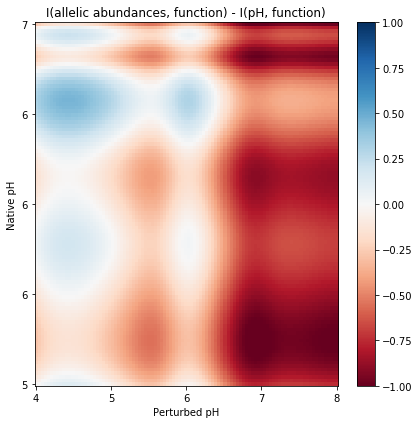

In [118]:
# Define the min and max values for the axes
x_min, x_max = 3.8, 8.4# example range for y-axis
y_min, y_max = 5, 7 # example range for x-axis

data = abundance_MI - pH_MI

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Display the matrix using imshow
cax = ax.imshow(data, cmap = 'RdBu', origin='lower', aspect='auto', vmin = -1, vmax = 1)

# Set custom tick positions and labels
num_ticks = 5  # number of ticks to show
x_ticks = np.linspace(0, data.shape[1] - 1, num_ticks)
y_ticks = np.linspace(0, data.shape[0] - 1, num_ticks)
x_labels = np.linspace(x_min, x_max, num_ticks)
y_labels = np.linspace(y_min, y_max, num_ticks)

ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{label:.0f}" for label in x_labels])
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{label:.0f}" for label in y_labels])

# Add colorbar and labels
plt.colorbar(cax, ax=ax)
ax.set_xlabel("Perturbed pH")
ax.set_ylabel("Native pH")
ax.set_title("I(allelic abundances, function) - I(pH, function)")

# Show the plot
plt.tight_layout()
plt.show()

## Testing functions

['Soil14_CE_251_N2_-2_None_T9', 'Soil14_CE_251_N2_-23_None_T9', 'Soil14_CE_251_N2_-5_None_T9', 'Soil14_CE_251_N2_-8_None_T9', 'Soil14_CE_251_N2_-90_None_T9', 'Soil14_CE_251_N2_0_None_T9', 'Soil14_CE_251_N2_14_None_T9', 'Soil14_CE_251_N2_2_None_T9', 'Soil14_CE_251_N2_22_None_T9', 'Soil14_CE_251_N2_5_None_T9', 'Soil14_CE_251_N2_9_None_T9']


In [ ]:
for soil in soils:
    print(soil, native_pH(soil))

In [12]:
print(native_pH('Soil15'))

6.789


In [ ]:
print(find_orfs(get_filepath('T0', 'annotation'), 'K00370'))

In [ ]:
print(find_orfs_from_cluster('Soil17.scaffold_502405353_c1_1'))

In [ ]:
print(find_cluster_from_orf('T0.scaffold_334770953_c1_1'))

In [ ]:
#Soil5, 6, 9, 11, 12, 14, 15, 16, 17
prefixes = ['T0', 'Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']

for prefix in prefixes:
    ORFS = find_clustered_orfs(get_filepath(prefix, 'annotation'), 'K00370')
    print(prefix, '\n')
    print(len(ORFS))


Below, I'm looking to find out which cluster IDs are present in all soils. This is also completed in track_clusters.py

In [ ]:
##want to find out which clusters are found everywhere 

soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']

cluster_IDs = pd.read_csv('out/cluster_ids.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]

cluster_tracker = np.zeros((len(cluster_IDs), len(soils)))


for soil in soils:
    yes = 0
    no = 0
    col_idx = soils.index(soil)
    ORFS = find_orfs(get_filepath(soil, 'annotation'), 'K00370')
    for orf in ORFS:
        cluster = find_cluster_from_orf(orf)
        if cluster in cluster_IDs:
            row_idx = cluster_IDs.index(cluster)
            yes += 1
            print('yes')
            cluster_tracker[row_idx, col_idx] = 1
        else:
            no += 1
            print('no')
    print(soil, 'yes = ', yes, 'no = ', no)
    
print(cluster_tracker)
        